# HDF5 Vs Pickle

In [1]:
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import pickle
import h5py

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "figure.figsize": [5, 3]
})

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
ydim = 10000

In [4]:
gb = 8589934592 # bits

In [5]:
mb = 8000000 # bits

In [6]:
expected_memory = 1 * ydim * 64
expected_memory = expected_memory * 1/mb

In [7]:
expected_memory # in Mb

0.08

#### Dump to Pickle

In [8]:
xdim_vec = np.arange(1000, 10000, 1000)

pickle_times = []

for xdim in xdim_vec:
    test_data = np.ones(shape=(xdim, ydim), dtype=np.float64)
    runs = []
    
    for i in range(5):
        start = time.time()
        with open(f'test_pickle_{xdim}.pkl', 'wb') as f:
            pickle.dump(test_data, f)
        runs.append(time.time()-start)
    pickle_times.append(runs)

In [9]:
pickle_times = np.array(pickle_times)

In [10]:
memory_vec = xdim_vec * ydim * 64/mb

#### Dump to hdf5

In [11]:
xdim_vec = np.arange(1000, 10000, 1000)

hdf5_times = []

for xdim in xdim_vec:
    test_data = np.ones(shape=(xdim, ydim), dtype=np.float64)

    runs = []
    
    for i in range(5):
        start = time.time()
        with h5py.File(f'test_hdf5_{xdim}.hdf5', 'w') as f:
            f.create_dataset('test', data=test_data)
        runs.append(time.time()-start)
    hdf5_times.append(runs)

In [12]:
hdf5_times = np.array(hdf5_times)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


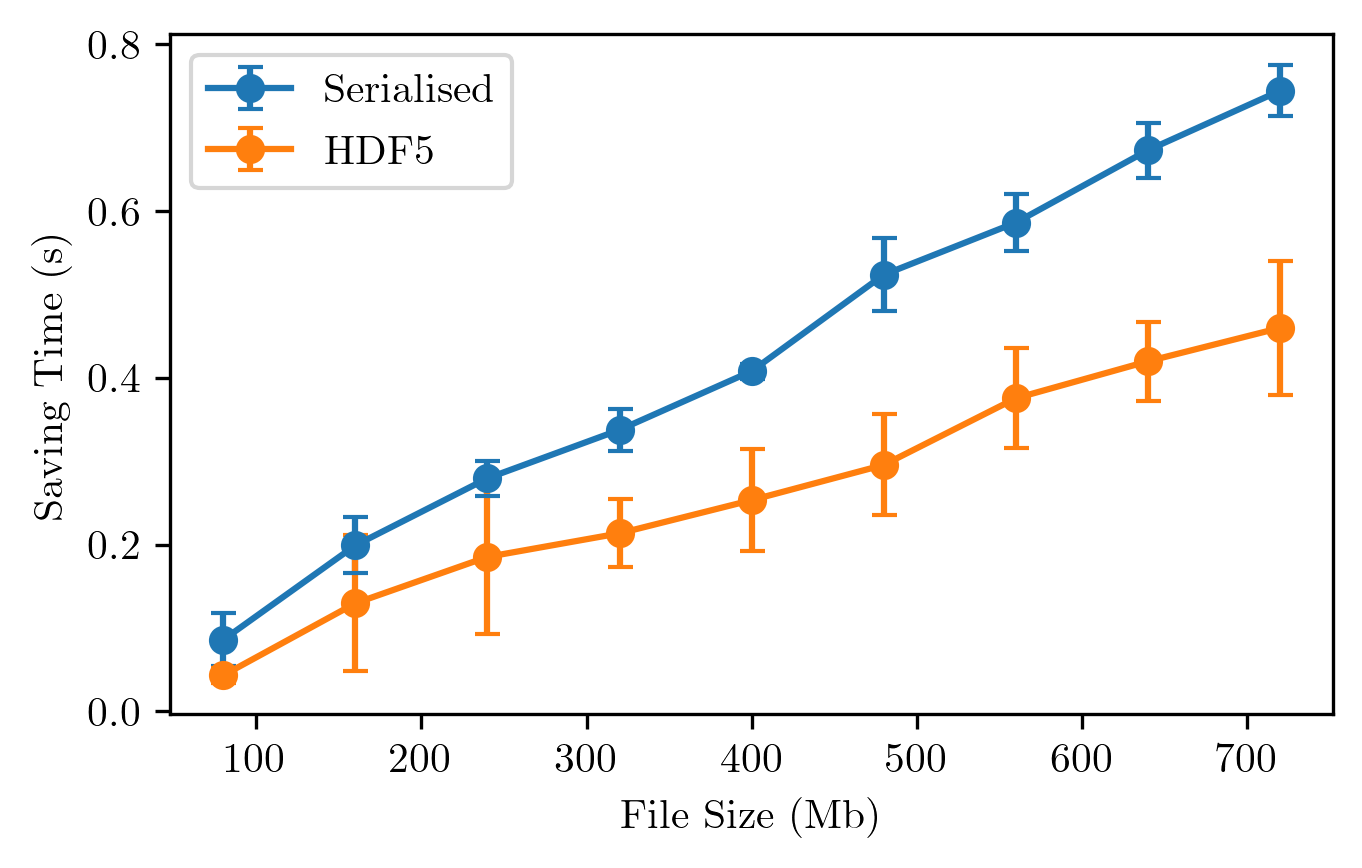

In [13]:
fig, ax = plt.subplots()

ax.errorbar(x=memory_vec, y=pickle_times.mean(axis=1), marker='o', yerr=pickle_times.std(axis=1), capsize=3, label='Serialised')
ax.errorbar(x=memory_vec, y=hdf5_times.mean(axis=1), marker='o', yerr=hdf5_times.std(axis=1), capsize=3, label='HDF5')
ax.set_xlabel('File Size (Mb)')
ax.set_ylabel('Saving Time (s)')
plt.legend()
plt.show()

In [25]:
speedup = pickle_times.mean(axis=1)/hdf5_times.mean(axis=1)
speedup_error = np.sqrt((pickle_times.std(axis=1)/pickle_times.mean(axis=1))**2 + (hdf5_times.std(axis=1)/hdf5_times.mean(axis=1))**2)

fig, ax = plt.subplots()
ax.errorbar(x=memory_vec, y=speedup, yerr=speedup_error, capsize=3, marker='o')
ax.set_xlabel('File Size (Mb)')
ax.set_ylabel('Multiplicative Speedup')

plt.show()

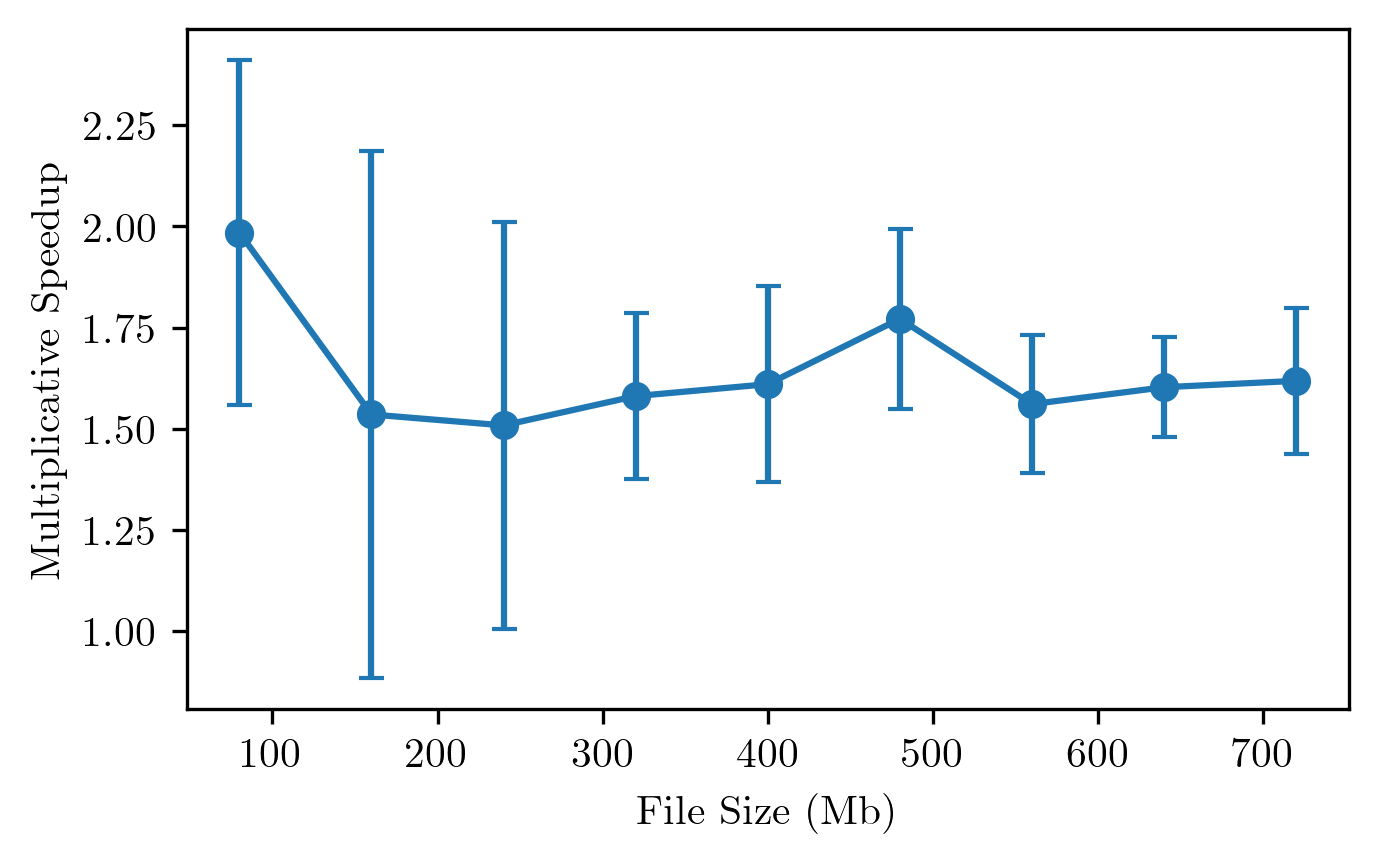

#### Test load times

In [31]:
def load_pickle(filename, dirpath):
    """
    Load pickled object.
    Parameters:
    -----------
    filename : str 
    dirpath : str
    Returns:
    --------
    object
    """

    dirpath = pathlib.Path(dirpath)
    filepath = dirpath / f'{filename}.pkl'

    with open(filepath, 'rb') as f:
        obj = pickle.load(f)

    return obj


def load_hdf5(filename, dirpath):
    """
    Load HDF5 file from disk.
    Parameters:
    -----------
    filename : str
    dirpath : str
    Returns:
    --------
    h5py.File
    """
    dirpath = pathlib.Path(dirpath)
    filepath = dirpath / f'{filename}.hdf5'

    return h5py.File(filepath, 'r')


In [32]:
xdim_vec = np.arange(1000, 10000, 1000)

pickle_load_times = []

for xdim in xdim_vec:
    test_data = np.ones(shape=(xdim, ydim), dtype=np.float64)
    runs = []
    
    for i in range(5):
        start = time.time()
        pickle_loaded = load_pickle(f'test_pickle_{xdim}', '')
        runs.append(time.time()-start)
    pickle_load_times.append(runs)


In [33]:
xdim_vec = np.arange(1000, 10000, 1000)

hdf5_load_times = []

for xdim in xdim_vec:
    test_data = np.ones(shape=(xdim, ydim), dtype=np.float64)
    runs = []
    
    for i in range(5):
        start = time.time()
        hdf5_loaded = load_hdf5(f'test_hdf5_{xdim}', '')
        hdf5_loaded['test'][:]
        runs.append(time.time()-start)
    hdf5_load_times.append(runs)
    

In [34]:
pickle_load_times = np.array(pickle_load_times)
hdf5_load_times = np.array(hdf5_load_times)

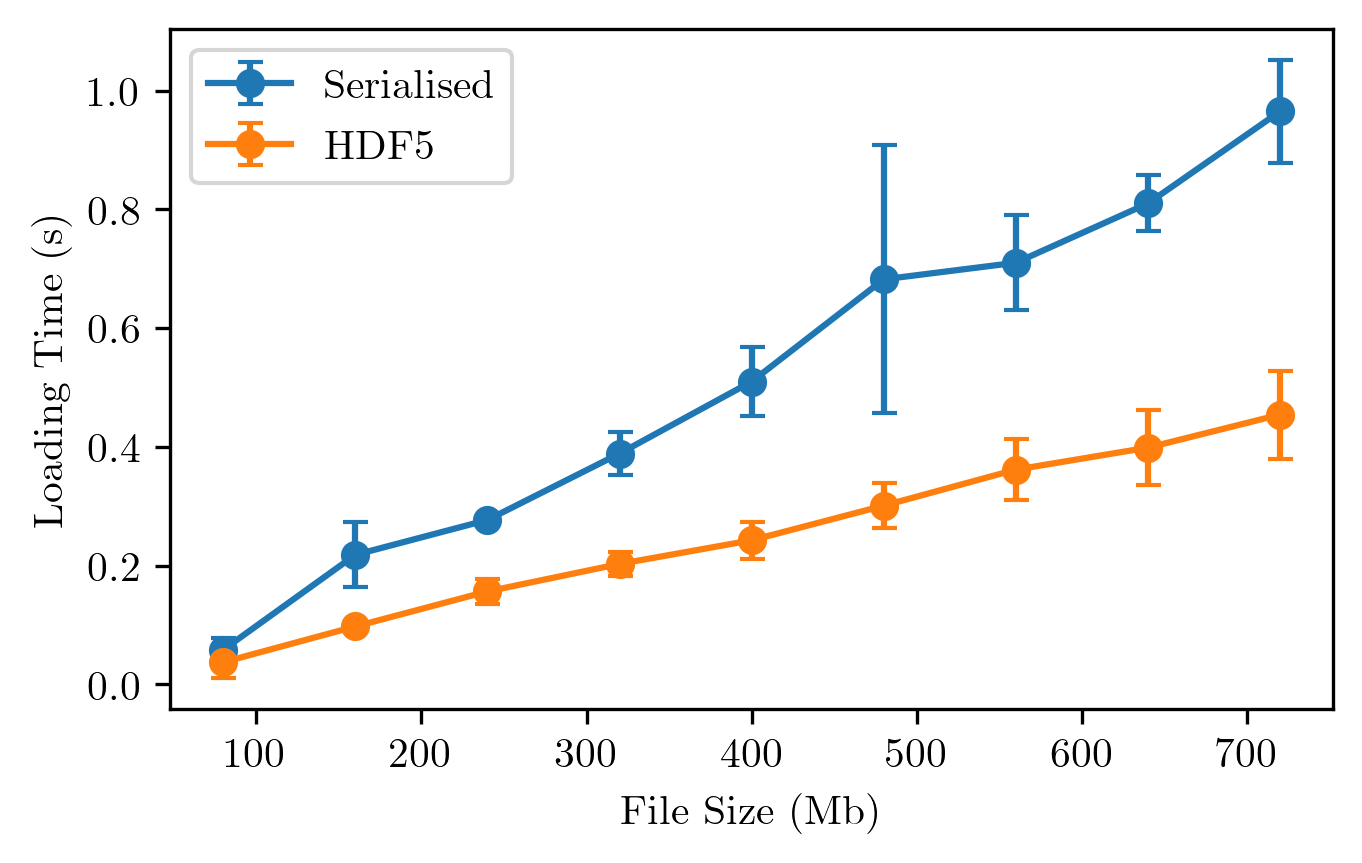

In [35]:
fig, ax = plt.subplots()
ax.errorbar(x=memory_vec, y=pickle_load_times.mean(axis=1), marker='o', yerr=pickle_load_times.std(axis=1), capsize=3, label='Serialised')
ax.errorbar(x=memory_vec, y=hdf5_load_times.mean(axis=1), marker='o', yerr=hdf5_load_times.std(axis=1), capsize=3, label='HDF5')

ax.set_xlabel('File Size (Mb)')
ax.set_ylabel('Loading Time (s)')
plt.legend()
plt.show()

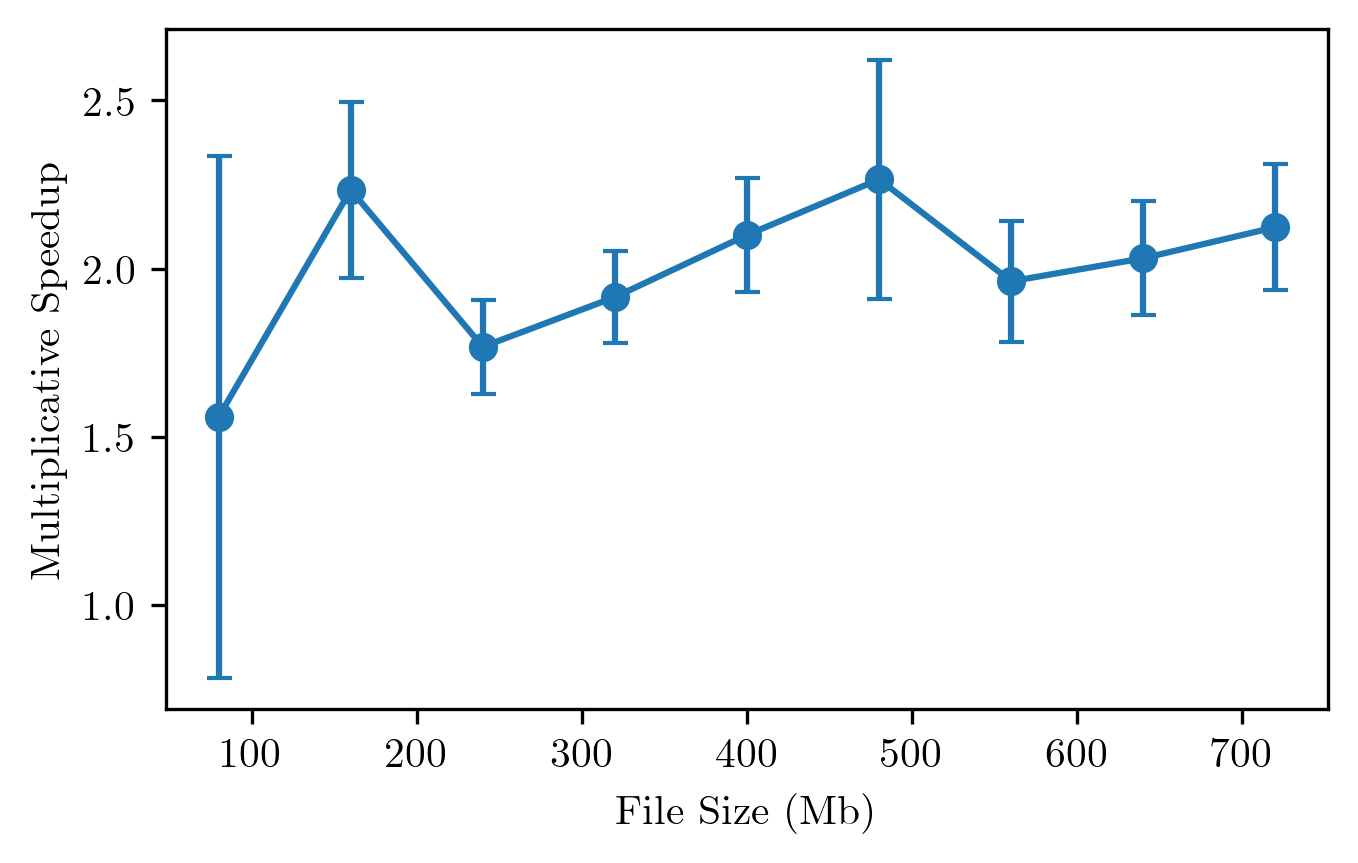

In [42]:
speedup = pickle_load_times.mean(axis=1)/hdf5_load_times.mean(axis=1)
speedup_error = np.sqrt((pickle_load_times.std(axis=1)/pickle_load_times.mean(axis=1))**2 + (hdf5_load_times.std(axis=1)/hdf5_load_times.mean(axis=1))**2)

fig, ax = plt.subplots()
ax.errorbar(x=memory_vec, y=speedup, yerr=speedup_error, capsize=3, marker='o')
ax.set_xlabel('File Size (Mb)')
ax.set_ylabel('Multiplicative Speedup')

plt.show()

#### polyfit loading time

In [36]:
np.polyfit(memory_vec, pickle_load_times.mean(axis=1), deg=1)

array([ 0.00136712, -0.03340575])

In [37]:
np.polyfit(memory_vec, hdf5_load_times.mean(axis=1), deg=1)

array([ 0.00064168, -0.00619381])

In [38]:
0.00131163 / 0.00065136

2.0136790714812087

~2X speedup for load time

#### polyfit saving time

In [39]:
np.polyfit(memory_vec, pickle_times.mean(axis=1), deg=1)

array([0.00101108, 0.02180171])

In [40]:
np.polyfit(memory_vec, hdf5_times.mean(axis=1), deg=1)

array([0.0006247 , 0.01404299])

In [41]:
0.00109064 / 0.000611396074

1.7838518210700842

~1.8x speedup for save time